# PPO to Beat Mario

## Background

In the ACM AI Spring 2023 Deep RL workshop, I made a DDQN to play Mario. It took about 13000 episodes to train and performed pretty well on level 1-1 of NES Mario (TODO: INSERT LINK).

Here, I implement PPO from scratch to solve Mario, with the aim of reducing train time and improving performance.

## Setup and Some Exploration

First, we install gymnasium and the Mario Env.

The Mario env can be found here: https://pypi.org/project/gym-super-mario-bros/

In [1]:
# uncomment if using colab; if running locally it's recommended to install via conda
# !pip uninstall -y gym
# !pip install gymnasium
# !pip install gym_super_mario_bros==7.3.0
# !pip install wandb

Before we transform the env with wrappers and make our agent, let's take a look at the environment as-is. Below we take some random actions and generate a video

In [2]:
import gymnasium as gym
from gym.wrappers import RecordVideo

from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

import numpy as np

import warnings
warnings.filterwarnings('ignore')

env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", apply_api_compatibility=True, render_mode='rgb_array')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

def run_test(env, num_steps=50):
    frames = []
    out = env.reset()
    for _ in range(num_steps):
        next_state, reward, done, truncated, info = env.step(action=env.action_space.sample())
        frames.append(np.copy(env.render()))
    return frames

frames = run_test(env)

In [3]:
print(frames[-1].shape)

(240, 256, 3)


We can reuse the following code to see what our bot does later on:

In [4]:
from IPython.display import HTML
from base64 import b64encode
import numpy as np
import os
import cv2
from tqdm import tqdm

def display_vid(frames, vid_name='./video.mp4', fps=30, fourcc='vp90'):

    if os.path.isfile(vid_name):
      !rm video.mp4

    h, w, c = frames[-1].shape
    out = cv2.VideoWriter(vid_name, cv2.VideoWriter_fourcc(*fourcc), fps, (w, h))
    for frame in tqdm(frames):
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        out.write(img)
    out.release()

    mp4 = open(vid_name,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

In [5]:
display_vid(frames)

'rm' is not recognized as an internal or external command,
operable program or batch file.
100%|██████████| 50/50 [00:00<00:00, 303.87it/s]


## Preprocessing Environment

The original DDQN DeepMind papers for Atari games transforms the environments to make it easier for their DQN/DDQN to learn. In particular,

1. Use only every 4th frame
2. Grayscale each image, downscale to 110x84, then crop appropriately to remove unnecesssary info
3. Pass a stack of 4 frames so that the model can see trajectory (falling and jumping are different contexts, but may lead to the same observation).


We will implement some of these simplifying transformations for our PPO using Gymnasium's `gym.Wrapper`. Wrapper code is altered from https://blog.paperspace.com/building-double-deep-q-network-super-mario-bros/.

In [6]:
import collections
import cv2

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        self._obs_buffer = collections.deque(maxlen=2)
        self._replay_buffer = collections.deque(maxlen=4)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, truncated, info = self.env.step(action)
            self._obs_buffer.append(obs)
            self._replay_buffer.append(obs.copy())
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, truncated, info

    def render(self, mode='rgb_array'):
        if mode == 'rgb_array':
            return self._replay_buffer
        
        return self.env.render(mode=mode)

    def reset(self, **kwargs):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, observation):
        return ProcessFrame84.process(observation)

    @staticmethod
    def process(frame):
        assert frame.size == 240 * 256 * 3, "Unknown resolution."

        img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class TransposeObs(gym.ObservationWrapper):
    def __init__(self, env):
        super(TransposeObs, self).__init__(env)
        w, h, n = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(n, w, h), dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, observation):
        return np.array(observation).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self, **kwargs):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset()), {}

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation[0]
        return self.buffer

In [7]:
from gym.wrappers import FrameStack
from nes_py.wrappers import JoypadSpace

def preprocessed_env(world=1, level=1, movement='right'):
    from gym_super_mario_bros.actions import RIGHT_ONLY, SIMPLE_MOVEMENT, COMPLEX_MOVEMENT

    env = gym_super_mario_bros.make(f'SuperMarioBros-{world}-{level}-v0', apply_api_compatibility=True, render_mode='rgb_array')
    env = MaxAndSkipEnv(env)
    env = ProcessFrame84(env)
    env = TransposeObs(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)

    print(f'SuperMarioBros-{world}-{level}-v0', movement)

    if movement == 'right':
        return JoypadSpace(env, RIGHT_ONLY)
    if movement == 'simple':
        return JoypadSpace(env, SIMPLE_MOVEMENT)

    return JoypadSpace(env, COMPLEX_MOVEMENT)

In [8]:
env = preprocessed_env()
print('obs space', env.observation_space.shape)
print('act space', env.action_space.n)

SuperMarioBros-1-1-v0 right
obs space (4, 84, 84)
act space 5


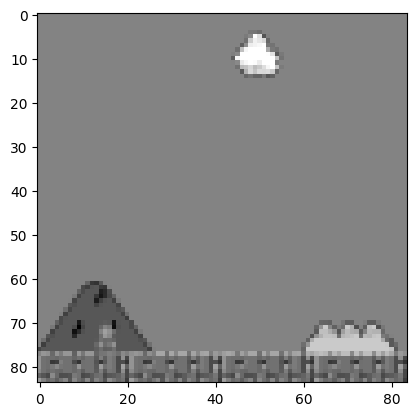

In [9]:
import matplotlib.pyplot as plt

plt.imshow(env.reset()[0][-1], cmap='gray')

We now have a preprocessed environment! We can proceed to working on our Agent.

## Training Convolutional PPO

I will be adapting a previous PPO implementation I made (https://github.com/arth-shukla/ppo-gym-cartpole) for training.

I will be adding the following features:
1. CNNs for actor and critic to process frame obs
2. early stop based on approx kl
3. advantage normalization
4. entropy regularization
5. GAE
6. normal DL techniques like grad normalization and lr scheduling

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
from ppo.agent import PPOAgent
from tqdm import tqdm
import torch
from pathlib import Path

def train(
    logging=True, log_init=True, wandb_proj='Mario-PPO', group_name=None, run_name=None, job_type=None,
    world=1, level=1, movement='right', hard_lr_shift_avg_rew = None,
    checkpoint_dir = './checkpoints', pretrained_path=None,
    num_games = 2000, avg_over = 100, save_every = 100,
    buffer_size = 512,
    batch_size = 16,
    epochs = 10,
    lr = 1e-4,
    scheduler_gamma = None,
    discount = .9,
    gae_lambda = 1.0,
    policy_clip = 0.2,
    norm_advantage = False,
    entropy_coeff = None,
    critic_coeff = 0.5,
    max_grad_norm = None,
    early_stop_kl = None,
    embed = 512,
):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
        print('created', checkpoint_dir)

    import wandb

    if logging and log_init:
        wandb.login()
        wandb.init(project=wandb_proj, name=run_name, job_type=job_type, group=group_name, config=dict(
            buffer_size = buffer_size,
            batch_size = batch_size,
            epochs = epochs,
            lr = lr,
            scheduler_gamma = scheduler_gamma,
            discount = discount,
            gae_lambda = gae_lambda,
            policy_clip = policy_clip,
            norm_advantage = norm_advantage,
            entropy_coeff = entropy_coeff,
            critic_coeff = critic_coeff,
            max_grad_norm = max_grad_norm,
            early_stop_kl = early_stop_kl,
            embed = embed,
        ))

    env = preprocessed_env(world=world, level=level, movement=movement)

    # create agent (note this is done in train because it needs hyperparams)
    agent = PPOAgent(
        obs_shape=env.observation_space.shape,
        act_shape=env.action_space.shape,
        act_n=env.action_space.n,
        buffer_size = buffer_size,
        batch_size = batch_size,
        epochs = epochs,
        lr = lr,
        scheduler_gamma = scheduler_gamma,
        discount = discount,
        gae_lambda = gae_lambda,
        policy_clip = policy_clip,
        norm_advantage = norm_advantage,
        entropy_coeff = entropy_coeff,
        critic_coeff = critic_coeff,
        max_grad_norm = max_grad_norm,
        early_stop_kl = early_stop_kl,
        embed = embed,
    )
    
    # load model if pretrained
    if pretrained_path != None:
        agent.load(load_path=pretrained_path)

    agent.actor.train()
    agent.critic.train()
    
    # data tracking
    score_hist = []
    num_steps = 0
    learn_steps = 0
    avg_score = 0
    best_score = 0

    # num_games is the number of games to play, where each game ends
    # when the agent meets terminal conditions for the env
    for ep_num in tqdm(range(num_games)):

        obs = env.reset()[0].__array__()
        done = False
        score = 0
        steps = 0

        # run loop where model gathers data for "learn_every"
        # steps then learns using that information
        while not done:

            # choose action (actor)
            action, log_prob, val = agent.act(obs)

            # get results of action
            next_obs, reward, done, _, _ = env.step(action)

            # save data to memory for experience learning
            agent.cache(obs, action, log_prob, val, reward, done)

            # when buffer full, learn and clear mem
            if agent.mem_full():
                log_dict = agent.learn(next_obs.__array__())
                agent.clear_mem()

                if logging:
                    log_dict['learn_steps'] = learn_steps
                    wandb.log(log_dict)

                learn_steps += 1
                
            # update obs and tracking vars
            obs = next_obs.__array__()
            score += reward
            steps += 1
            num_steps += 1

        score_hist.append(score)
        
        if (ep_num % save_every == 0) or (ep_num == num_games - 1):
            save_path = Path(checkpoint_dir) / Path(f'mario_ppo_{ep_num}.pt')
            agent.save(save_path=save_path)

        
        if len(score_hist) > avg_over:
            avg_score = np.mean(score_hist[-avg_over:])
            if avg_score > best_score:
                best_score = avg_score
                best_save_path = Path(checkpoint_dir) / Path('mario_ppo_best_model.pt')
                agent.save(save_path=best_save_path)
            if hard_lr_shift_avg_rew != None and avg_score > hard_lr_shift_avg_rew:
                for g in agent.actor.optimizer.param_groups:
                    g['lr'] = 1e-5
                for g in agent.critic.optimizer.param_groups:
                    g['lr'] = 1e-5
    
        if logging:
            log_dict = {
                'train/total_rewards': score,
                'train/ep_len': steps,
                'ep_num': ep_num,
                'charts/actor_lr': agent.actor.optimizer.param_groups[0]['lr'],
                'charts/critic_lr': agent.critic.optimizer.param_groups[0]['lr'],
            }
            if len(score_hist) > avg_over:
                log_dict[f'train/avg_reward_last_{avg_over}'] = avg_score
            wandb.log(log_dict)

    env.close()
    wandb.finish()

If you'd like to run training, you can use the below code. It takes about 1-2 hours for 2000 iters on a 3070 w/ 8GB VRAM. However, I have some pretrained checkpoints:

1. Simple, standard PPO run
2. PPO with early stopping using approx KL divergence
3. PPO with advantage norming

Different combinations of different techniques might help (or harm) training performance as well. Image charts can be seen below for the three runs mentioned below, as well as all the other tests I ran. Interactive charts are available on WandB: https://wandb.ai/arth-shukla/Mario-PPO

Note that `run_name_1.0` indicates a run with `policy_clip=1.0`, likewise for `run_name_2.0`.

<img src='./assets/std_run.png' width='48%' style='float:left;padding:1%' />
<img src='./assets/adv_norm.png' width='48%' style='float:left;padding:1%' />
<img src='./assets/early_stop.png' width='48%' style='float:left;padding:1%' />
<img src='./assets/all_tests.png' width='48%' style='float:left;padding:1%' />

In [12]:
# This is one train run; different train runs shown above changes inputted hparams

# train(
#     logging=False, log_init=False, wandb_proj='my-proj', run_name=None,
#     checkpoint_dir = './checkpoints', pretrained_path=None,
#     num_games = 2000, avg_over = 100, save_every = 100,
#     buffer_size = 512,
#     batch_size = 16,
#     epochs = 10,
#     lr = 1e-4,
#     scheduler_gamma = None,
#     discount = .9,
#     gae_lambda = 1.0,
#     policy_clip = 0.2,
#     norm_advantage = False,
#     entropy_coeff = None,
#     critic_coeff = 0.5,
#     max_grad_norm = None,
#     early_stop_kl = None,
#     embed = 512,
# )

In [16]:
import wandb
wandb.finish()

charts/actor_lr,█████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
charts/critic_lr,█████████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ep_num,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learn_steps,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
losses/actor_loss,▆▇▆▆▆█▆▁▇▇▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
losses/approx_kl,▁▁▁▁▁█▁▅▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/critic_loss,█▄▃▂▁▁▁▂▂▄▃▂▃▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
losses/entropy,█▆▄▃▂▂▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▂▁▂▁▂▁▂▁
train/avg_reward_last_100,▁▁▁▂▂▂▃▄▄▄▄▃▃▄▅▄▅▅▅▆▆▇▇█▇▇▇▇▇▇▇▇▇▇██████
train/ep_len,▂▁▁▂▁▂▁▁▄▅▄▄▁▃▄█▇▄▄▅█▇▇▇▇▆▇▇▆▆▆▆▇▇██▇▇▇▇
train/total_rewards,▁▁▁▂▁▂▁▁▄▅▄▄▁▄▄▇▇▄▄▆███▇▇▇▇▇▇▇▇▇████████


In [14]:
NUM_TRIALS = 4
LEVELS = [(1, 4), (1, 3), (1, 2)]

In [15]:
for w, l in [(1,4)]:
    for i in range(NUM_TRIALS):
        group_name = f'w{w}_l{l}'
        run_name = group_name + f'_t{i}_hardlrshift'
        train(
            logging=True, log_init=True, wandb_proj='Mario-PPO', group_name=group_name, run_name=run_name, job_type='train',
            world=w, level=l, movement='simple',
            hard_lr_shift_avg_rew=1600,
            checkpoint_dir = f'./checkpoints/{group_name}/{run_name}', pretrained_path=None,
            num_games = 4000, avg_over = 100, save_every = 100,
            buffer_size = 512,
            batch_size = 16,
            epochs = 10,
            lr = 1e-4,
            scheduler_gamma = None,
            discount = .9,
            gae_lambda = 1.0,
            policy_clip = 0.2,
            norm_advantage = True,
            entropy_coeff = 0.01,
            critic_coeff = 0.5,
            max_grad_norm = 0.5,
            early_stop_kl = None,
            embed = 512,
        )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: arth-shukla. Use `wandb login --relogin` to force relogin


SuperMarioBros-1-4-v0 simple


 42%|████▏     | 1683/4000 [1:01:37<1:24:50,  2.20s/it]


KeyboardInterrupt: 

## Let's Watch Our Bot Play!

Below we have the code to run a level and save the rendered frames.

In [ ]:
def run_level(pretrained_path=None, world=1, level=1):
    with torch.no_grad():
        frames = []
        
        env = preprocessed_env(world=world, level=level, movement='right')

        agent = PPOAgent(
            obs_shape=env.observation_space.shape,
            act_shape=env.action_space.shape,
            act_n=env.action_space.n,
        )

        if pretrained_path != None:
            agent.load(pretrained_path)

        agent.actor.eval()
        agent.critic.eval()

        obs = env.reset()[0].__array__()
        done = False
        score = 0

        # run loop where model gathers data for "learn_every"
        # steps then learns using that information
        while not done:

            # choose action (actor)
            action, log_prob, val = agent.act(obs)

            # get results of action
            next_obs, reward, done, _, _ = env.step(action)

            # save data to memory for experience learning
            agent.cache(obs, action, log_prob, val, reward, done)

            # when buffer full, learn and clear mem
            if agent.mem_full():
                agent.learn(next_obs.__array__())
                agent.clear_mem()
                
            # update obs and tracking vars
            obs = next_obs.__array__()
            score += reward

            for x in env.render():
                frames.append(x.copy())
        
        env.close()

        return frames

In [ ]:
frames = run_level(pretrained_path='./selected_checkpoints/std_run_best_model.pt', world=1, level=1)

Let's watch our Standard PPO Run play Mario! Note that it might still lose sometimes...

In [ ]:
display_vid(frames, fps=60)